# Installing pip for CBLOF

In [22]:
pip install pyod

Note: you may need to restart the kernel to use updated packages.


# Importing files necessary for the code

In [23]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib
import scipy, json, csv, time, pytz
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from scipy.stats.mstats import zscore
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('fivethirtyeight')
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest 
from pyod.models.cblof import CBLOF
from datetime import datetime,tzinfo
from pytz import timezone
seed = 135
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Reading the Data

In [24]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS']="assistant1-366df-b820599fde13.json"
client = bigquery.Client()

# Query to transfer the date records into a dataframe

In [25]:
chunk_1 = """
SELECT 
   DATE(TIMESTAMP_MILLIS(timestamp)) AS Date,
   COUNT(transactions) AS Transactions
FROM `bigquery-public-data.bitcoin_blockchain.blocks`
GROUP BY date
HAVING date >= '2011-08-12' AND date <= '2020-08-12'
ORDER BY date
"""
query_job_1 = client.query(chunk_1)
iterator_1 = query_job_1.result(timeout=30)
rows_1 = list(iterator_1)
df_1 = pd.DataFrame(data=[list(x.values()) for x in rows_1], columns=list(rows_1[0].keys()))

# Query to transfer the Output_Satoshis, Blocks, Transaction records into another dataframe 

In [26]:
chunk_2 = """
SELECT
  o.Date,
  COUNT(o.block) AS Blocks,
  SUM(o.output_price) AS Output_Satoshis
FROM (
  SELECT
    DATE(TIMESTAMP_MILLIS(timestamp)) AS Date,
    output.output_satoshis AS output_price,
    block_id AS block
  FROM
    `bigquery-public-data.bitcoin_blockchain.transactions`,
    UNNEST(outputs) AS output ) AS o
GROUP BY
  o.date
HAVING o.date >= '2011-08-12' AND date <= '2020-08-12'
ORDER BY o.date, blocks
"""
query_job_2 = client.query(chunk_2)
iterator_2 = query_job_2.result(timeout=30)
rows_2 = list(iterator_2)
df_2 = pd.DataFrame(data=[list(x.values()) for x in rows_2], columns=list(rows_2[0].keys()))
df_2["Output_Satoshis"]= df_2["Output_Satoshis"].apply(lambda x: float(x/100000000))

# Merging the above two dataframes as "result"

In [27]:
result = pd.merge(df_1, df_2[['Date', 'Blocks', 'Output_Satoshis']],on='Date')
result.head()

,Date,Transactions,Blocks,Output_Satoshis
0,2011-08-12,131,15782,345156.334791
1,2011-08-13,130,18517,310575.996642
2,2011-08-14,132,22036,455081.468853
3,2011-08-15,129,19256,339976.157557
4,2011-08-16,147,22301,368317.941909


In [28]:
result.describe()

,Transactions,Blocks,Output_Satoshis
count,2587.000000,2.587000e+03,2.587000e+03
mean,154.613452,3.571232e+05,1.782853e+06
std,19.840893,2.709421e+05,2.391045e+06
min,2.000000,1.058500e+04,1.922581e+04
25%,142.000000,1.242885e+05,7.957505e+05
50%,153.000000,2.999070e+05,1.301581e+06
75%,166.000000,5.755845e+05,2.133016e+06
max,260.000000,2.035035e+06,6.735430e+07


# Exploratory Data Analysis

Text(0.5, 1.0, 'Bitcoin Transactions Done each day')

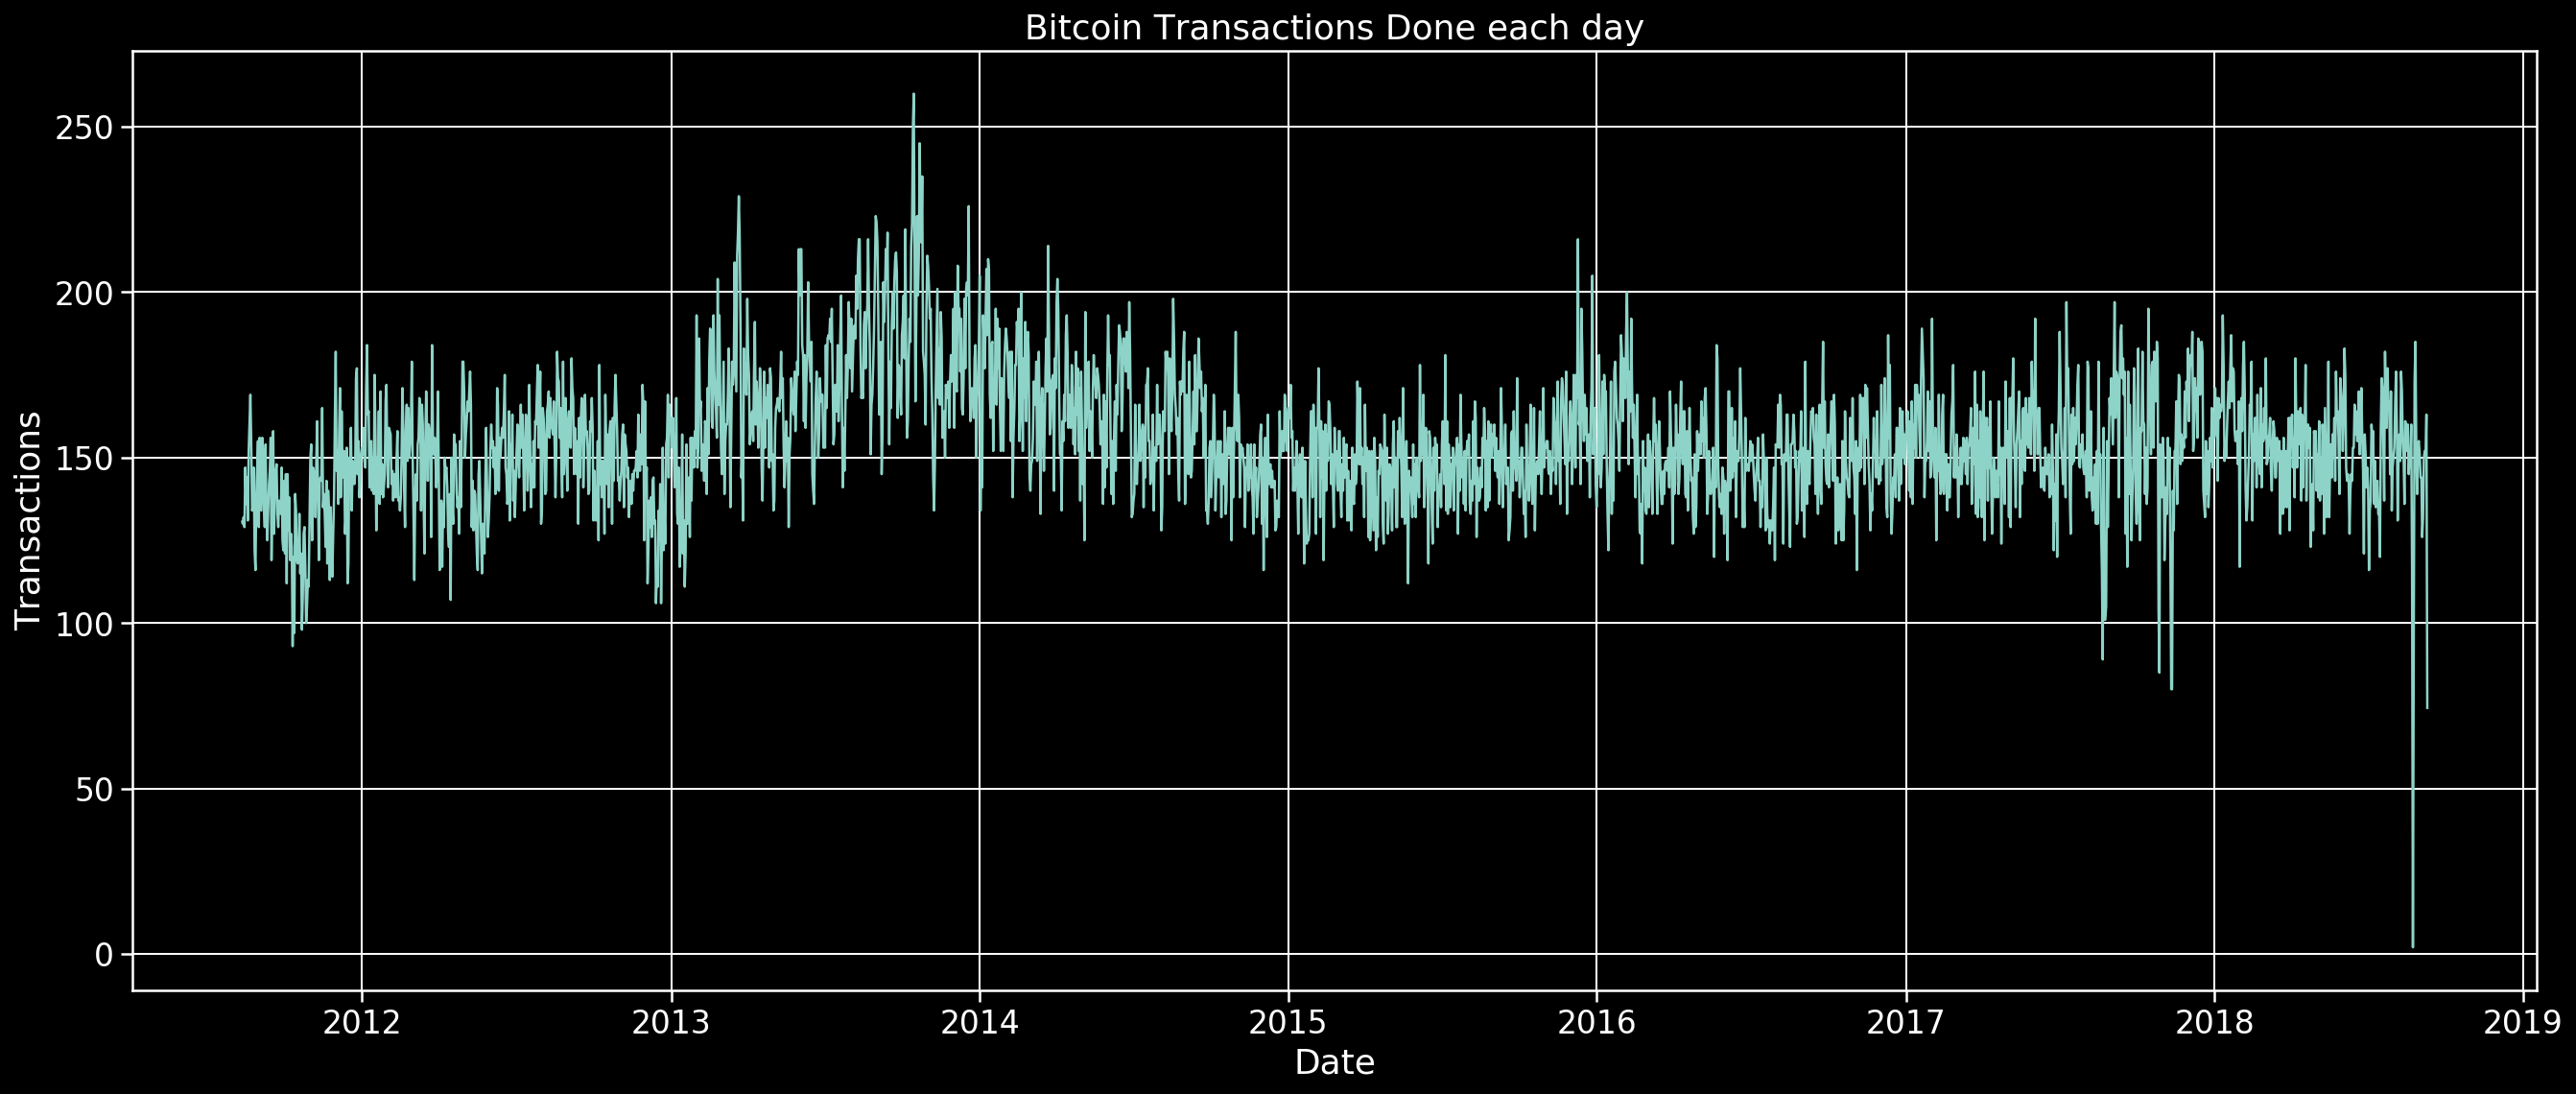

In [29]:
%matplotlib inline
plt.style.use('ggplot')
plt.style.use('dark_background')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.25})
g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='Date', y='Transactions', data=result, palette='Blues_d')
plt.title('Bitcoin Transactions Done each day')

Text(0.5, 1.0, 'Number of Blocks created each day')

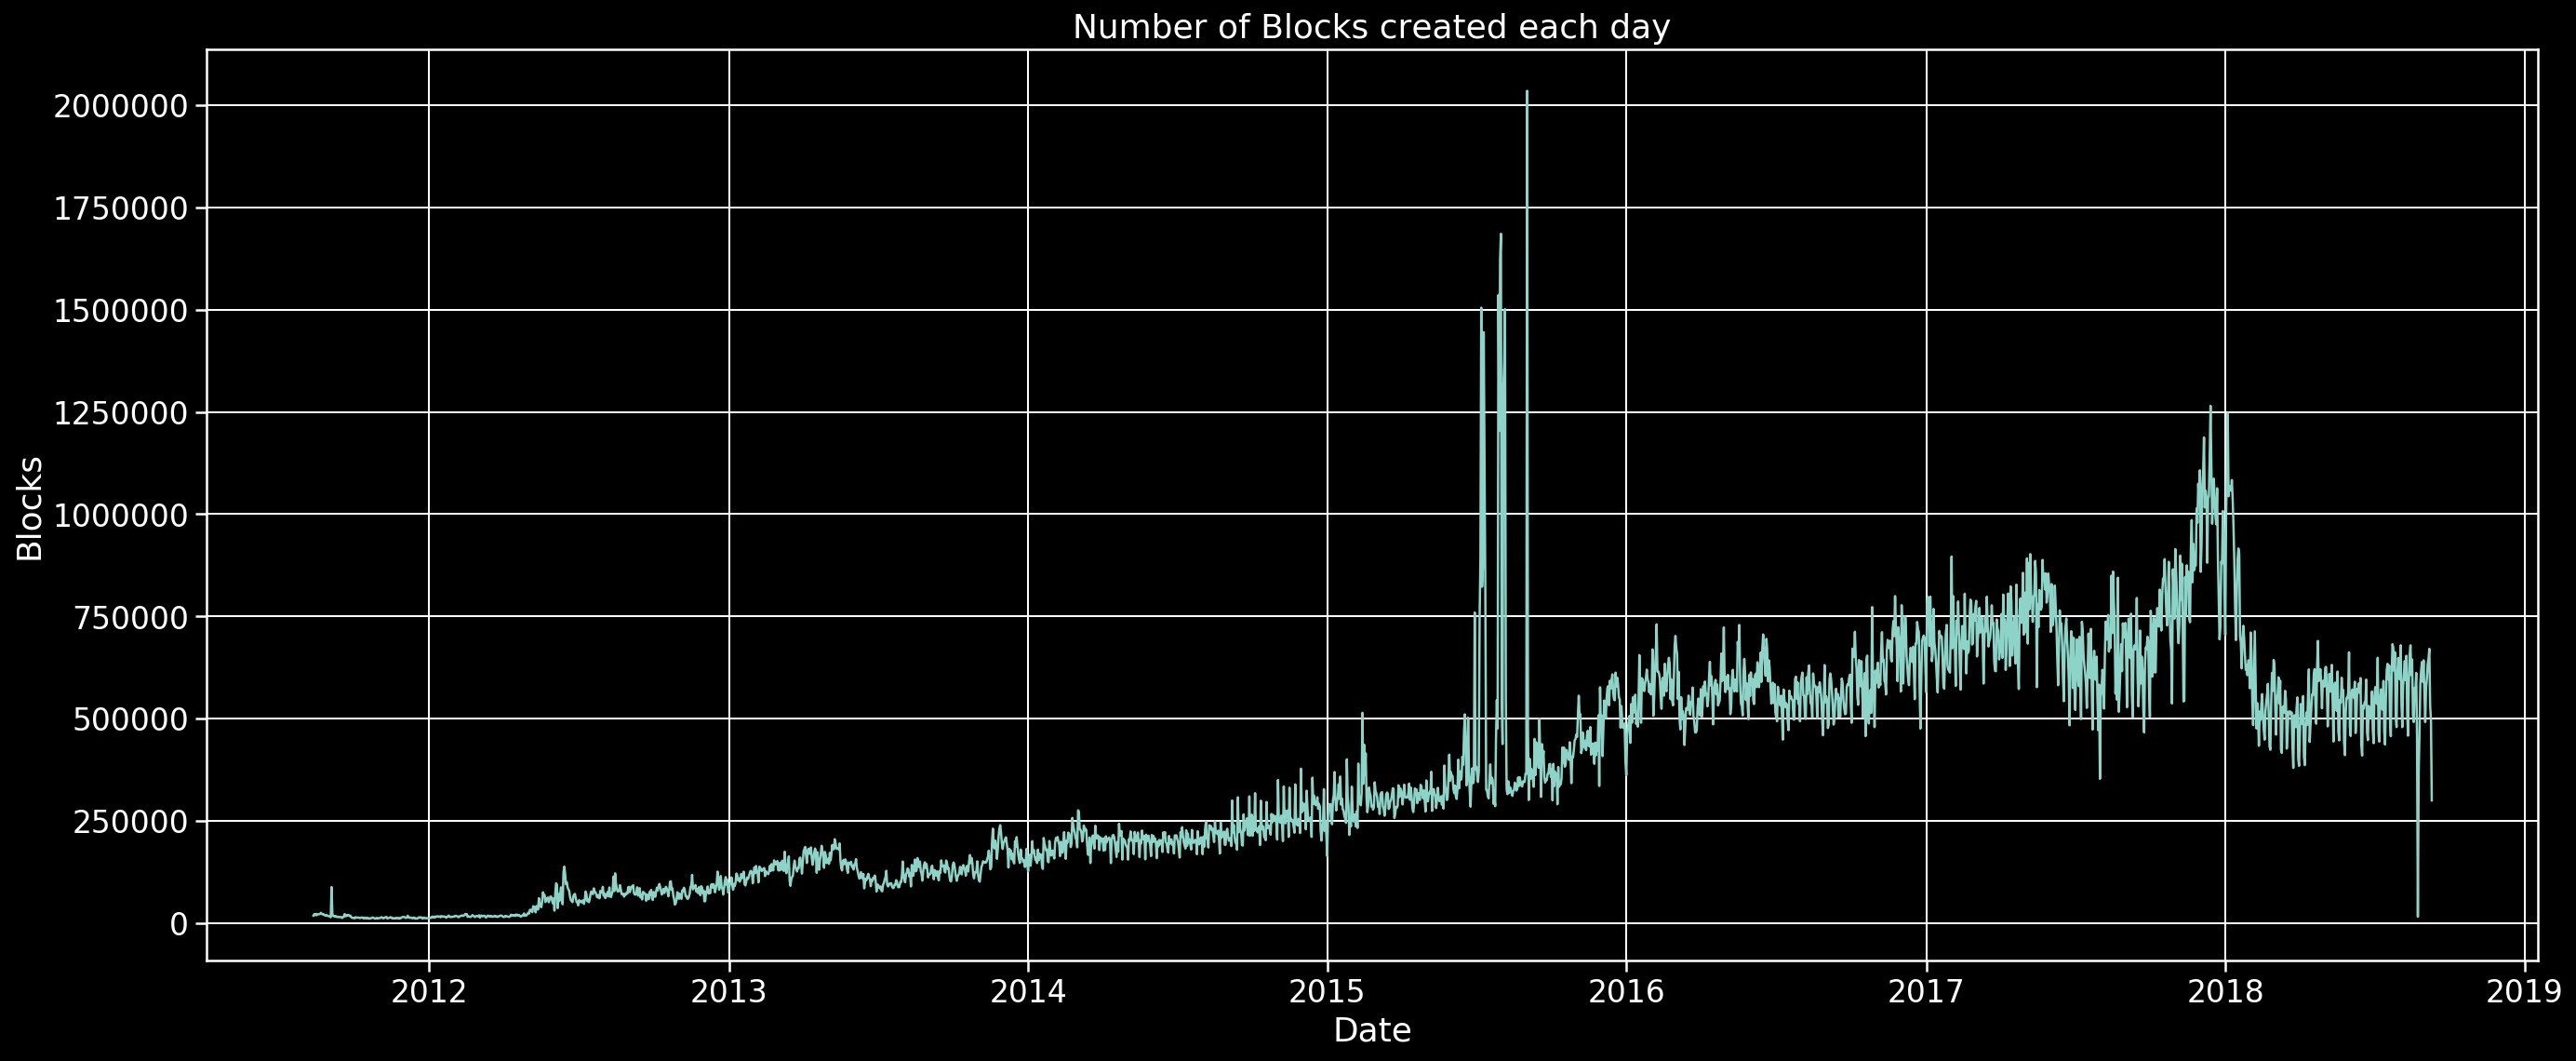

In [30]:
%matplotlib inline
plt.style.use('ggplot')
plt.style.use('dark_background')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.25})
g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='Date', y='Blocks', data=result, palette='Blues_d')
plt.title('Number of Blocks created each day')

Text(0.5, 1.0, 'Satoshis (Sum) released per day')

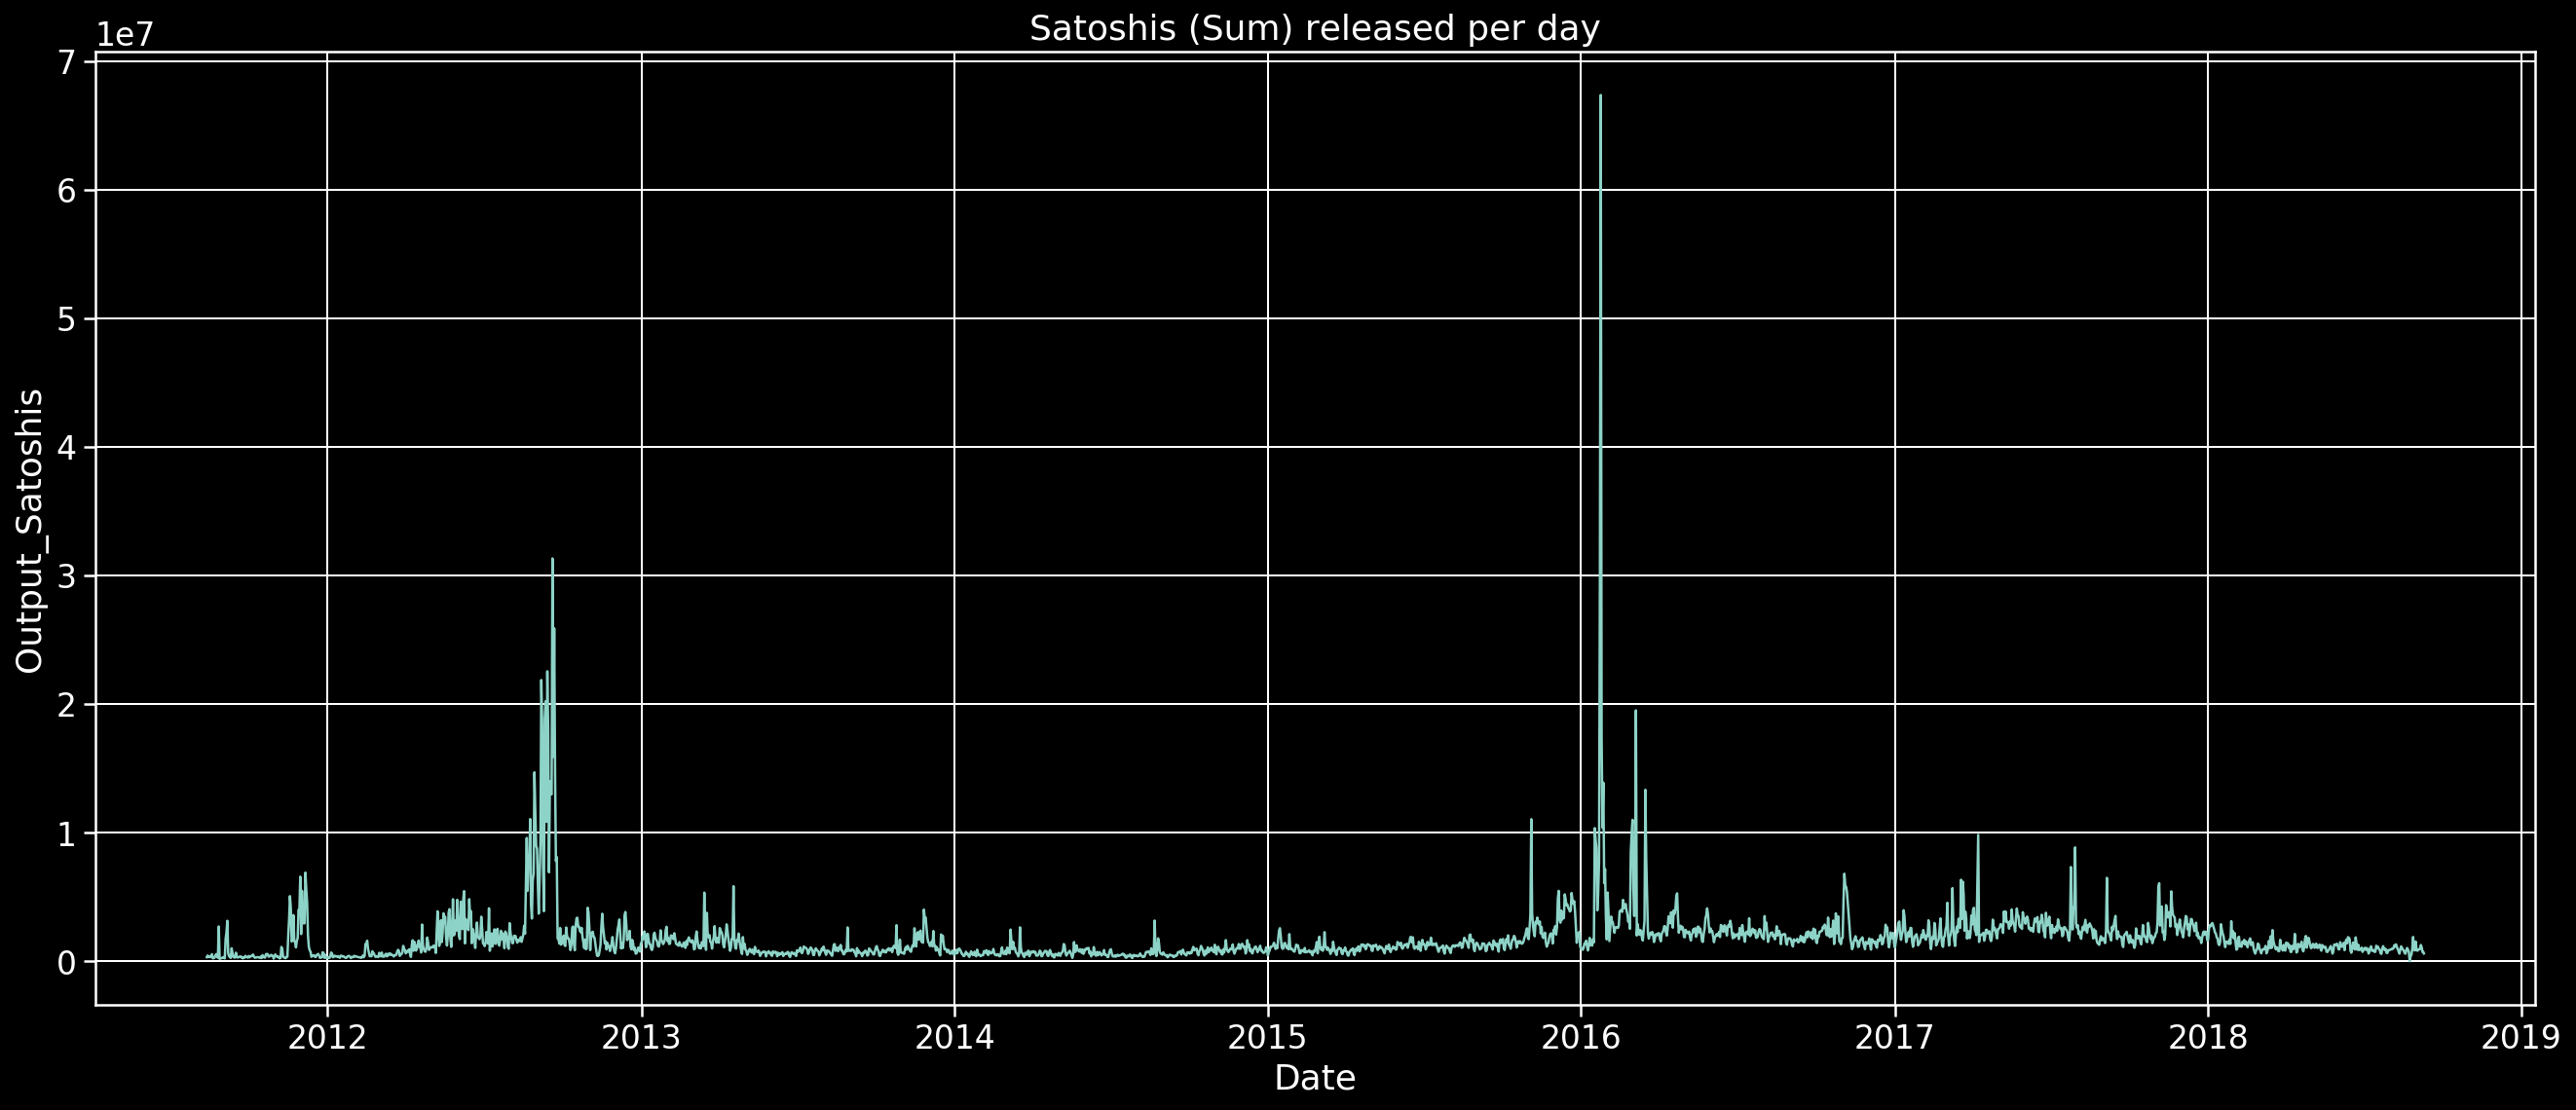

In [31]:
g = plt.subplots(figsize=(20,9))
plt.style.use('dark_background')
g = sns.lineplot(x='Date', y='Output_Satoshis', data=result, palette='BuGn_r')
plt.title('Satoshis (Sum) released per day')


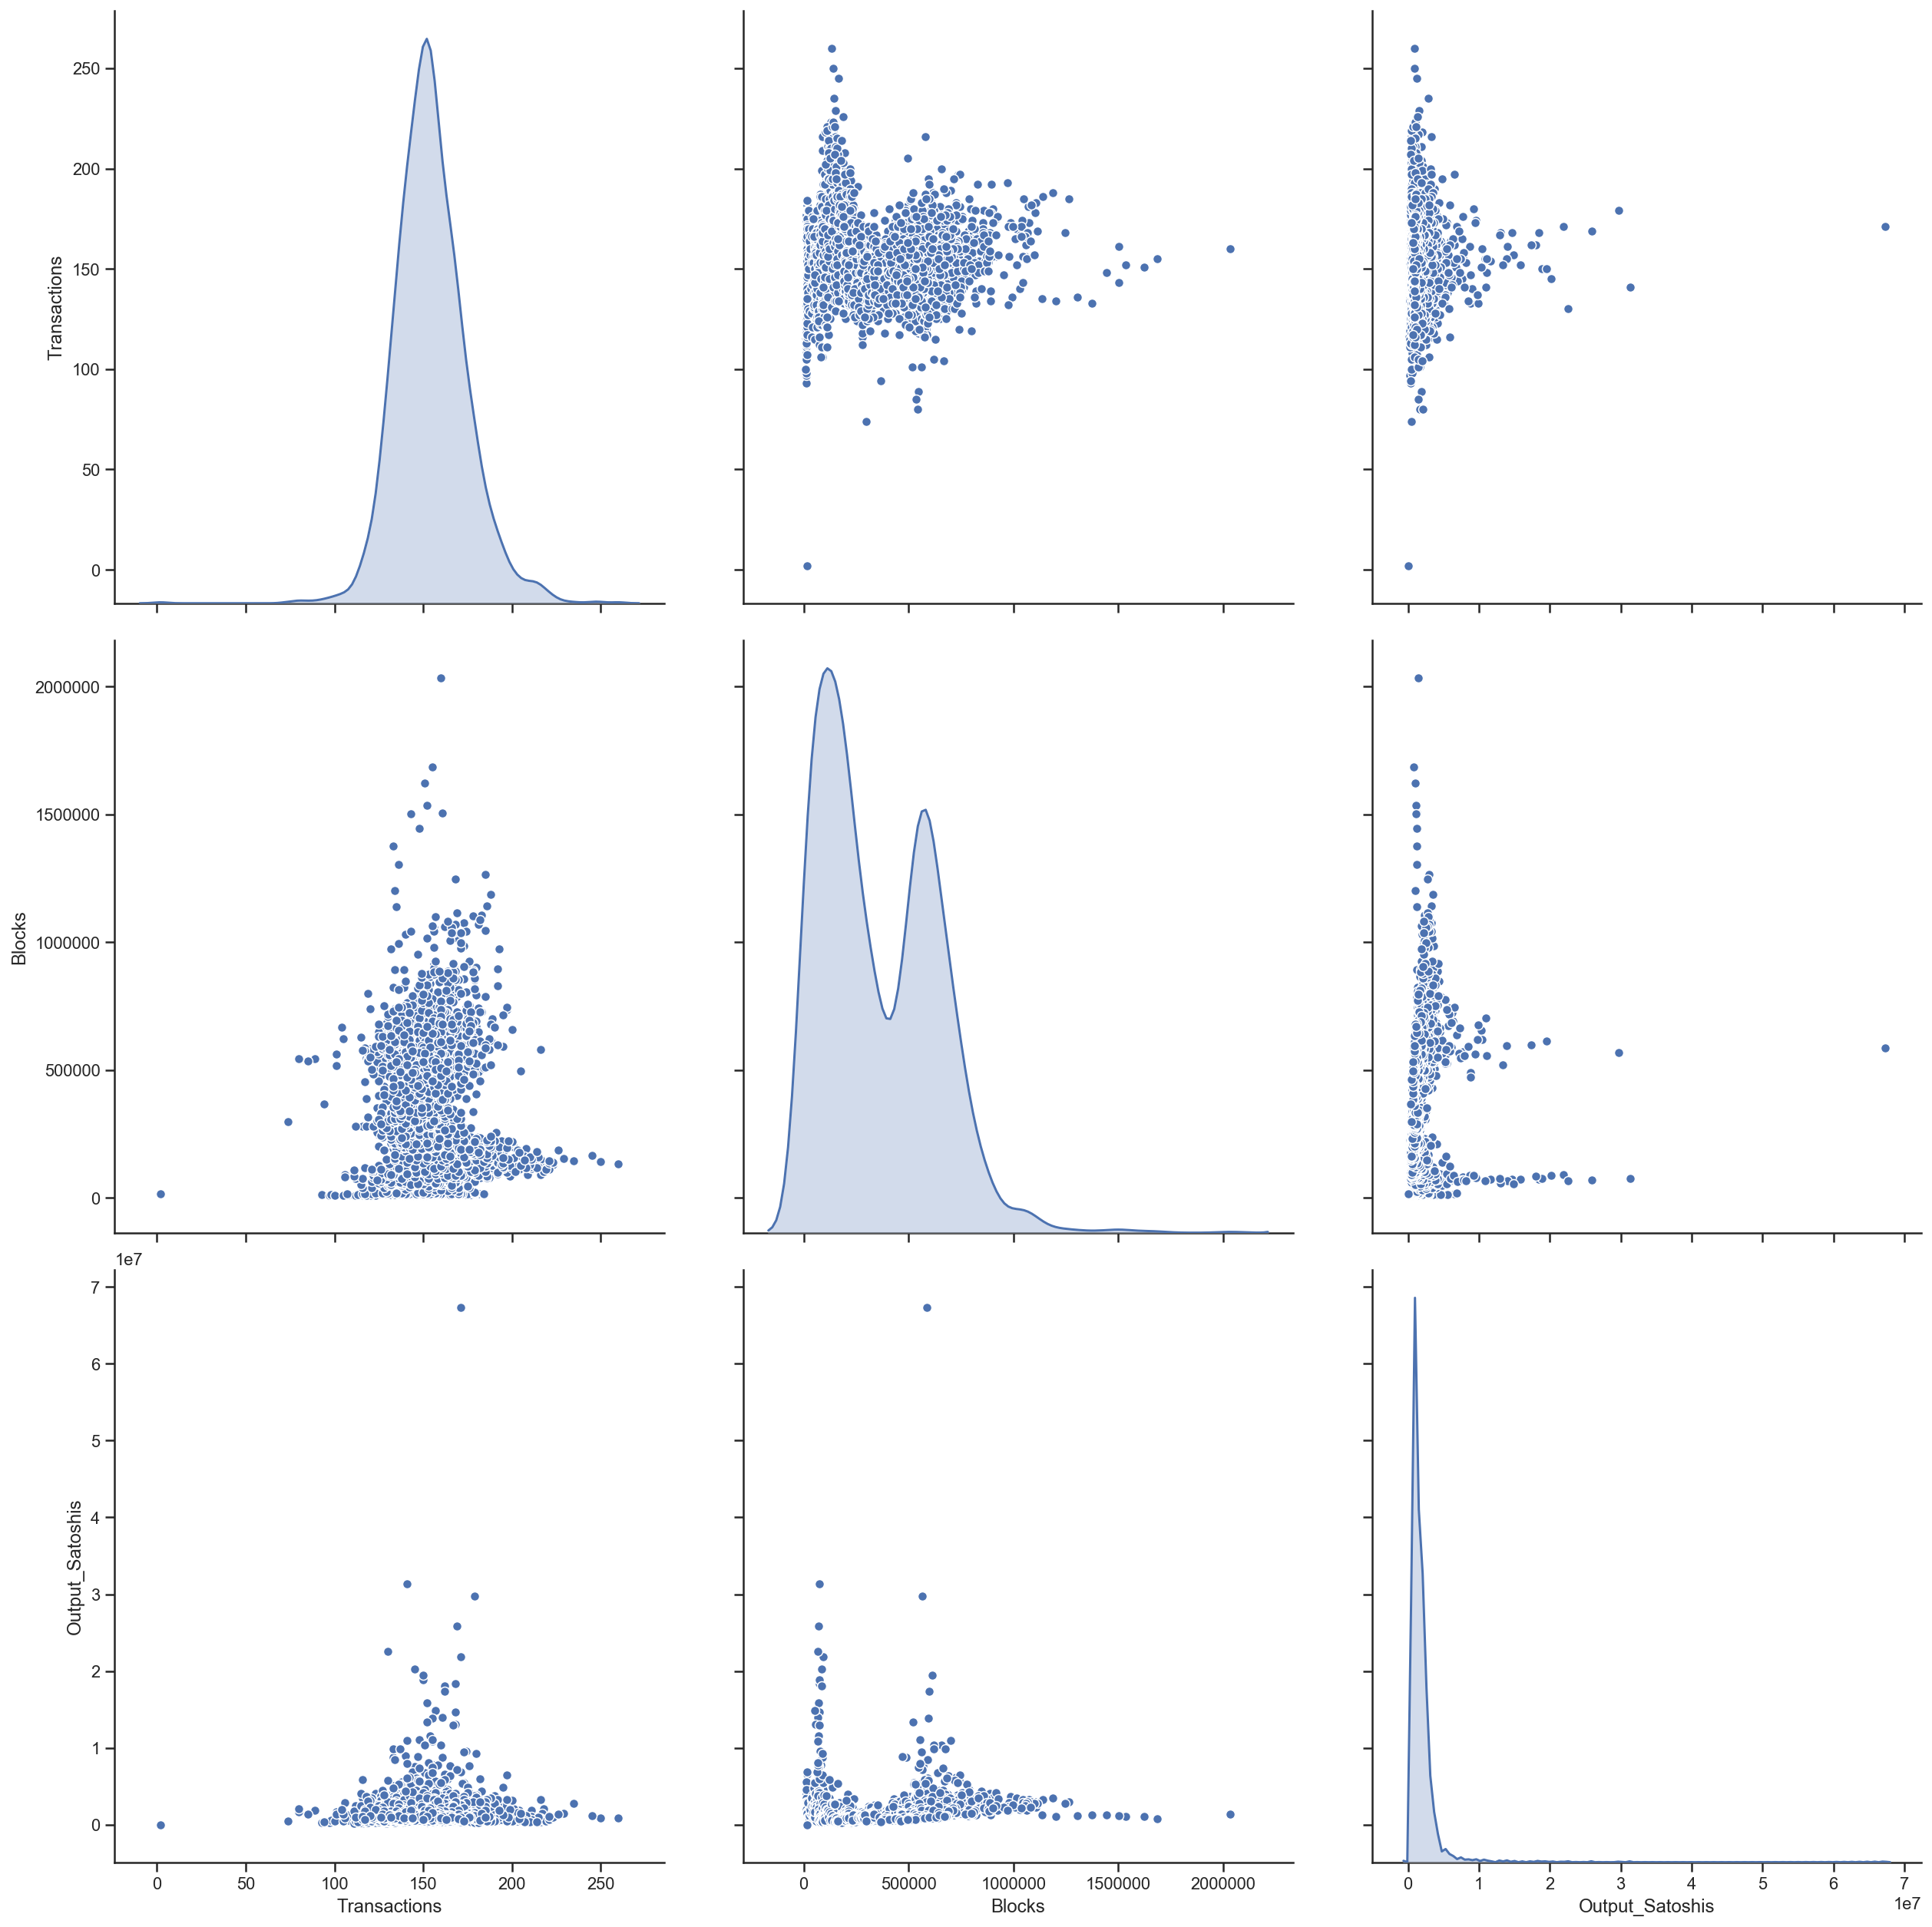

In [32]:
sns.set(style="ticks")
g = sns.pairplot(result, diag_kind = "kde",kind = "scatter",palette = "husl")
g.fig.set_size_inches(18,18)

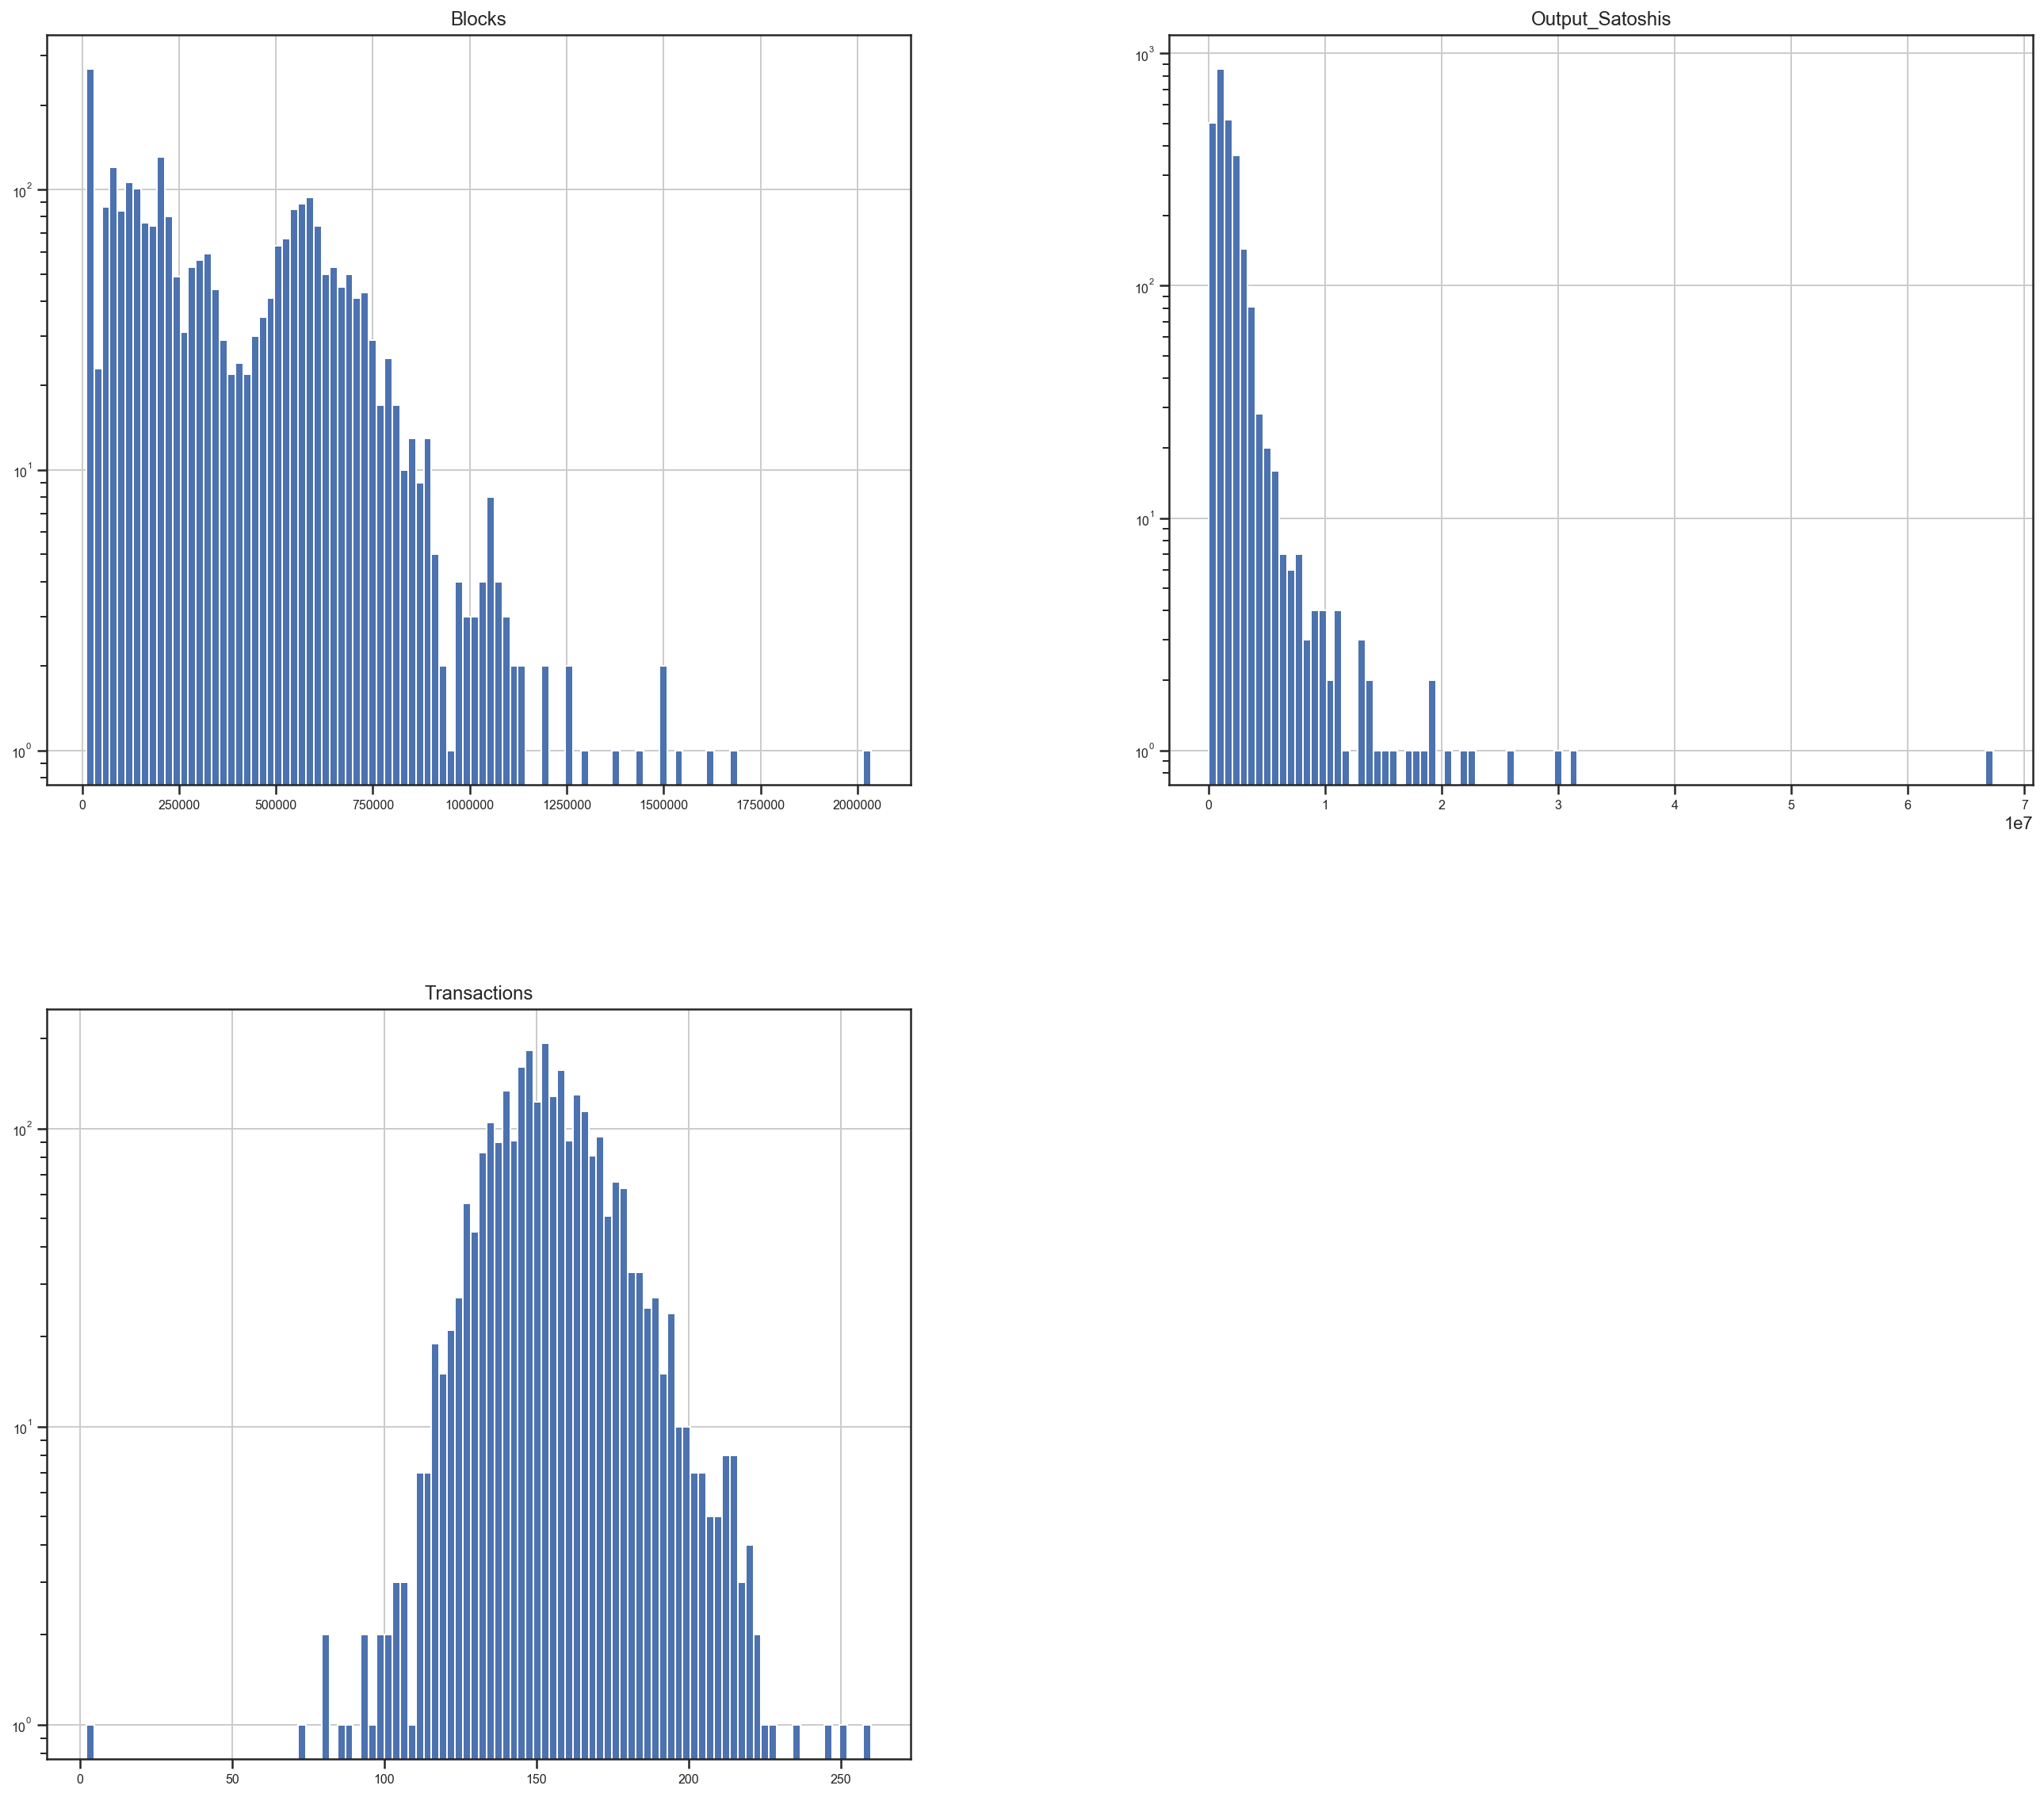

In [33]:
result.hist(figsize=(20, 20), bins=100, xlabelsize=8, ylabelsize=8, log=True);

# Setting Outlier Fraction and Formatting the Data

In [34]:
data = result[['Output_Satoshis','Blocks','Transactions']]
outliers_fraction=0.05
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
data.head()

,0,1,2
0,-0.601400,-1.260074,-1.190371
1,-0.615865,-1.249978,-1.240781
2,-0.555418,-1.236988,-1.139960
3,-0.603567,-1.247250,-1.291192
4,-0.591712,-1.236009,-0.383799


# Further Formatting the data and Feature engineering and obtaining the reduced data into a new data frame

In [35]:
data_original = data.copy()
data_original= data_original.reset_index(drop=True)
data_original[:] = MinMaxScaler().fit_transform(data_original[:])
pca = PCA(n_components=2)
pca.fit(data_original)
reduced_data = pca.transform(data_original)
reduced_data = pd.DataFrame(reduced_data)

In [36]:
reduced_data

,0,1
0,-0.166332,0.096988
1,-0.164880,0.100815
2,-0.163297,0.093019
3,-0.164367,0.104679
4,-0.165147,0.034902
...,...,...
2582,0.142607,0.013099
2583,0.154441,0.004933
2584,0.085738,0.014945
2585,0.066480,-0.034828


In [37]:
outliers_fraction = 0.05
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

# Fitting the model

In [38]:
clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)
clf.fit(reduced_data)
scores_pred = clf.decision_function(reduced_data) * -1
y_pred = clf.predict(reduced_data)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

In [39]:
plt.figure(figsize=(8, 8))

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [40]:
df1 = reduced_data
df1['outlier'] = y_pred.tolist()

In [41]:
df1

,0,1,outlier
0,-0.166332,0.096988,0
1,-0.164880,0.100815,0
2,-0.163297,0.093019,0
3,-0.164367,0.104679,0
4,-0.165147,0.034902,0
...,...,...,...
2582,0.142607,0.013099,0
2583,0.154441,0.004933,0
2584,0.085738,0.014945,0
2585,0.066480,-0.034828,0


In [42]:
df1.columns =['col1','col2','outlier'] 

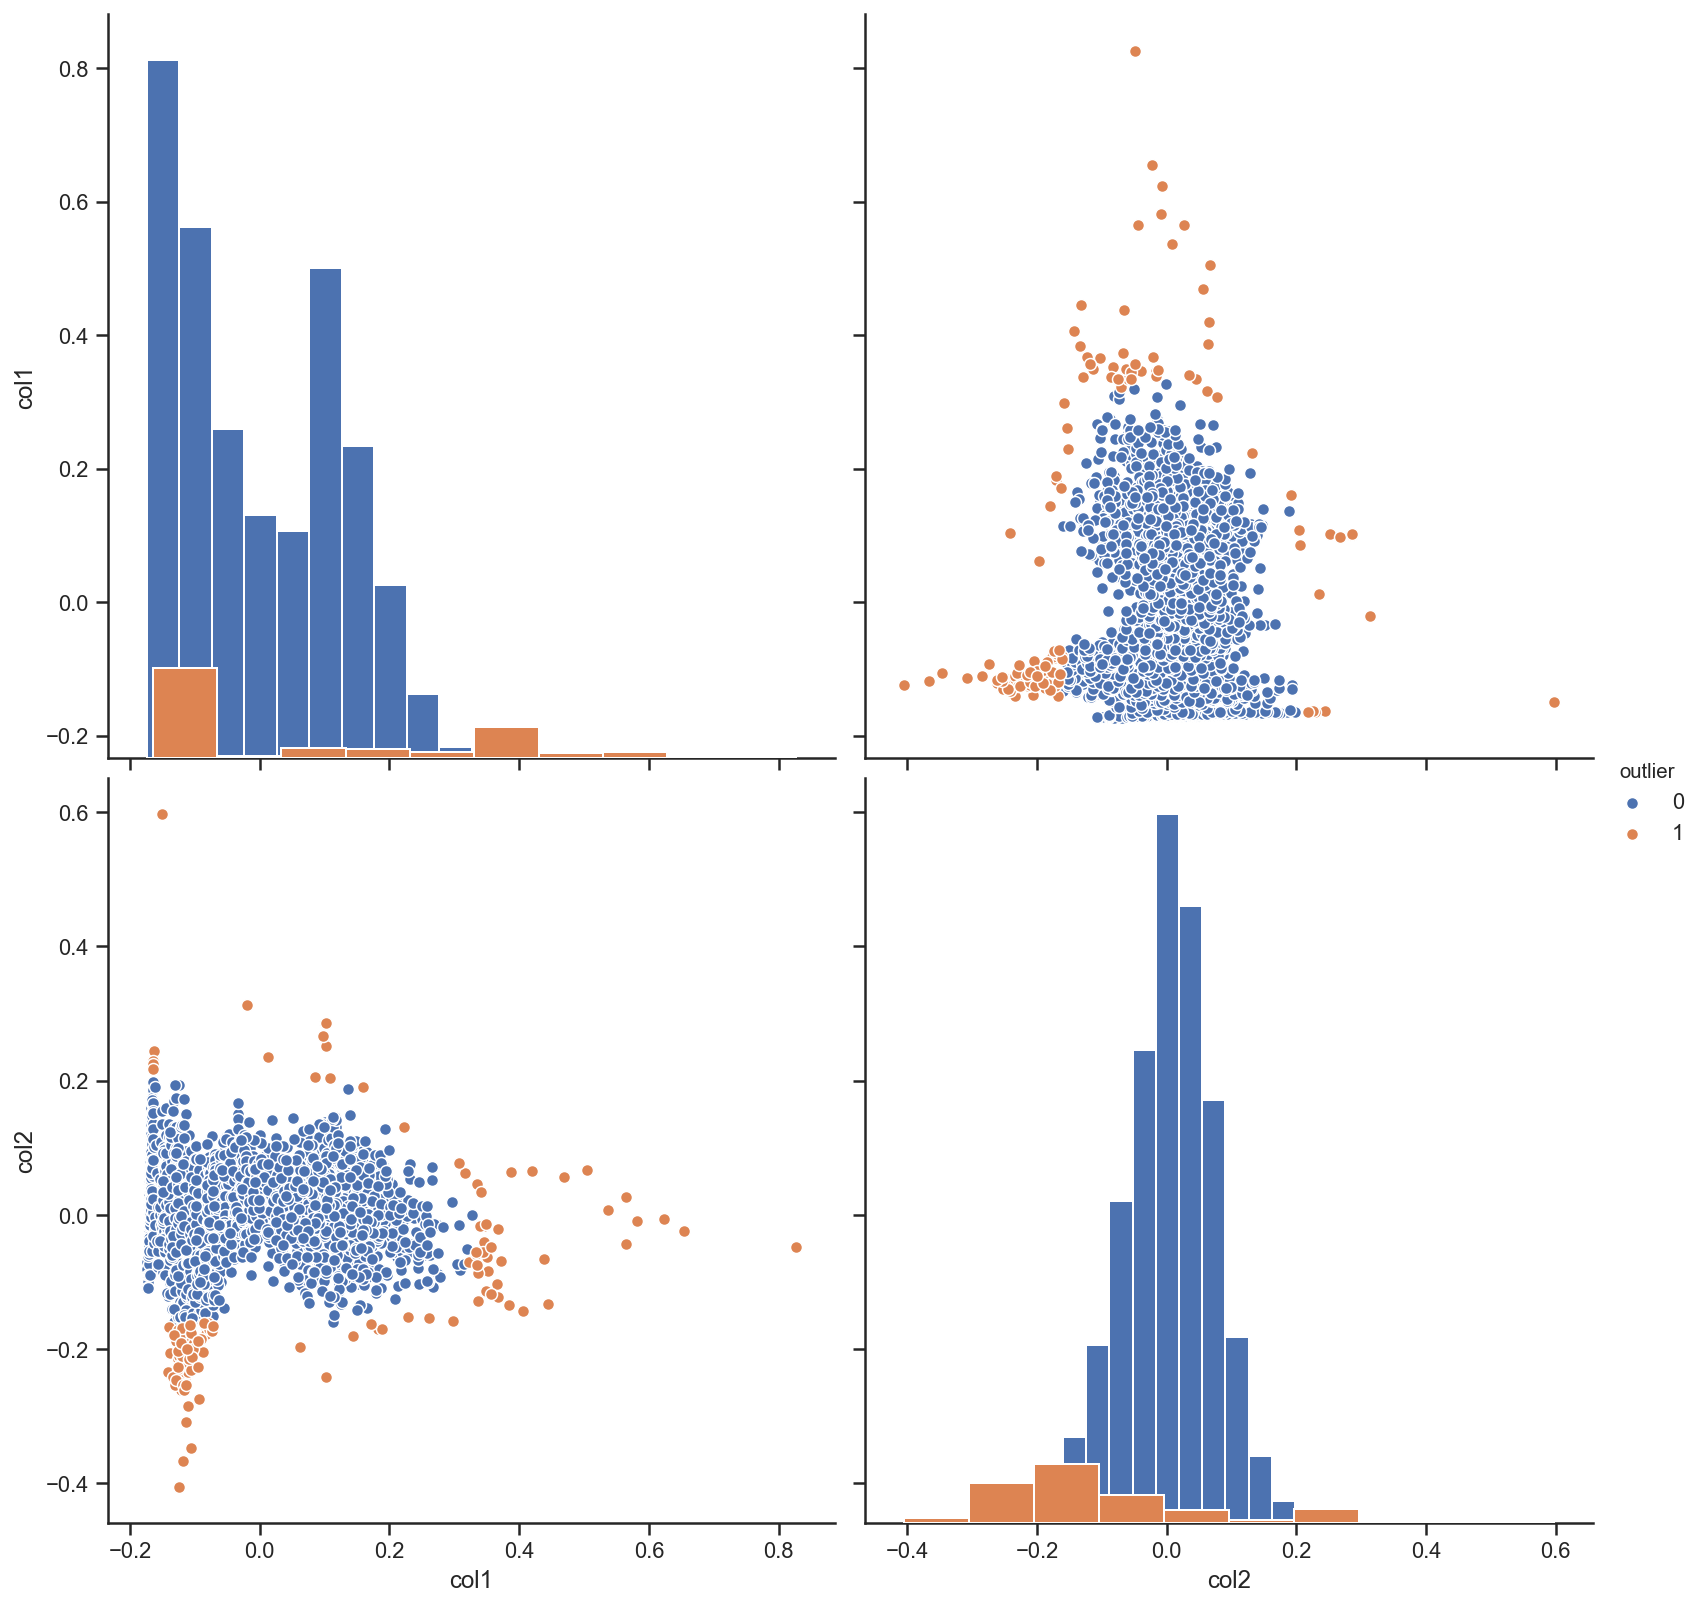

In [43]:
sns.pairplot(df1, hue='outlier', height=5.5,vars=["col1", "col2"],diag_kind="hist");

In [44]:
inliers_satoshis = np.array(df1['col1'][df1['outlier'] == 0]).reshape(-1,1)
inliers_blocks = np.array(df1['col2'][df1['outlier'] == 0]).reshape(-1,1)
outliers_satoshis = df1['col1'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_blocks = df1['col2'][df1['outlier'] == 1].values.reshape(-1,1)

# Calling the HBOS method using PYOD and Obtaining the results with Visual Representation

OUTLIERS: 130 INLIERS: 2457


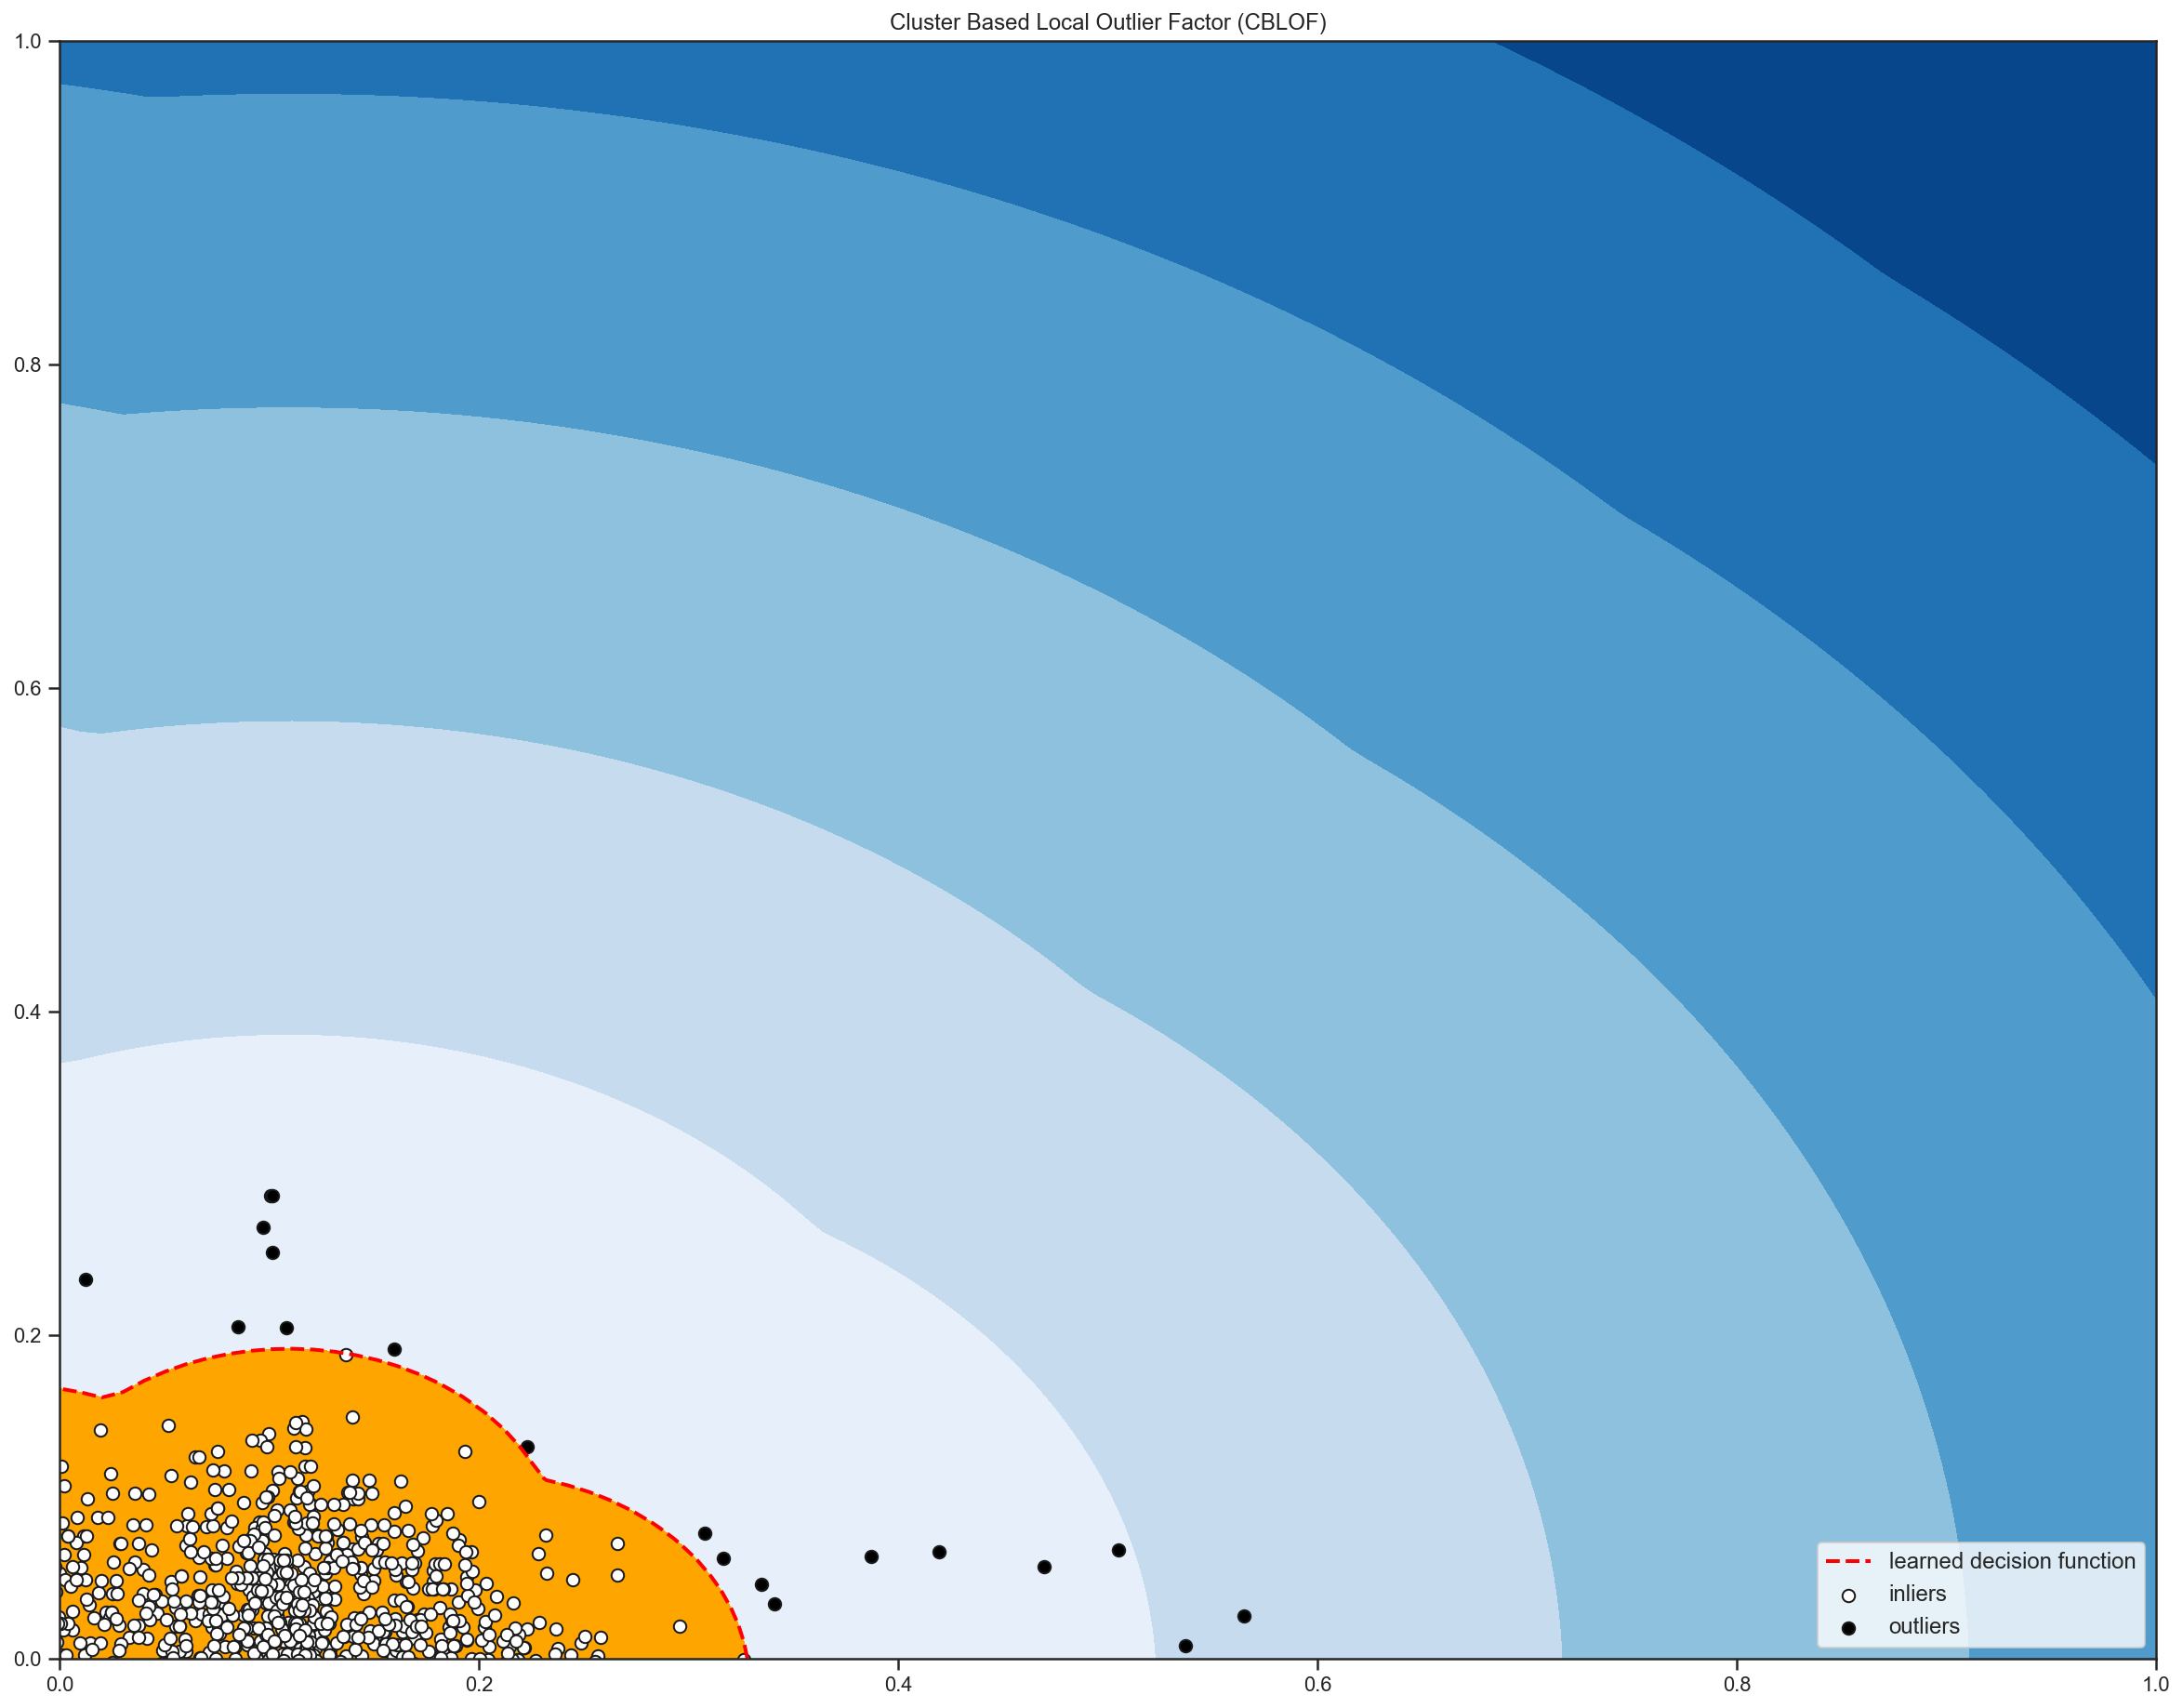

In [46]:
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
threshold = np.percentile(scores_pred, 100 * outliers_fraction)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_satoshis, inliers_blocks, c='white',s=45, edgecolor='k') 
c = plt.scatter(outliers_satoshis, outliers_blocks, c='black',s=45, edgecolor='k')    
plt.axis('tight')      
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'], prop=matplotlib.font_manager.FontProperties(size=12),loc='lower right')      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster Based Local Outlier Factor (CBLOF)')
plt.rcParams["figure.figsize"] = (18,16)
plt.show()